<h2>Primer modelo</h2>

In [1]:
# To import util functions
import os
import sys
module_path = os.path.abspath(os.path.join('../util'))
if module_path not in sys.path:
    sys.path.append(module_path)

import datasetManager_FF as dM
import cleaner_FF as cl
import transformer_FF as tr
import modeler_FF as md

In [2]:
#Common libraries for work with data
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy import stats


# np.set_printoptions(threshold=sys.maxsize)

#Plot libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Model libraries
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#Model training libraries
from sklearn.model_selection import train_test_split

#Metrics libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report

#Other
import pickle

/Users/fraferrari/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


<h3>Carga de datos (entrenamiento y validacion)</h3>

In [3]:
# Cargo el dataset
df = dM.cargar_datos(0.1)

In [4]:
# Limpia el dataset
cleaner = cl.Cleaner()
df = cleaner.clean_all(df)

In [5]:
# Transforma el dataset
transformer = tr.Transformer()
df = transformer.transform_all(df)

In [6]:
# Carga, limpia y transforma el dataset de validacion
validation = pd.read_csv('../datos/evaluation.csv')
validation = cleaner.clean_all(validation)
validation = transformer.transform_all(validation,df)

<h3>Modelado</h3>

In [11]:
modelador = md.Modeler()

In [9]:
features = df.loc[:, df.columns != 'Label']
labels = df.loc[:, df.columns == 'Label']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)


#tree_clf = RandomForestClassifier()

#tree_clf = XGBClassifier()

#tree_clf = LGBMClassifier()

"""
tree_clf = LGBMClassifier(n_estimators = 100, 
                       learning_rate = 0.3,
                       #max_features=8,
                       max_depth = 10, 
                       #num_leaves = 50,
                       min_data_in_leaf = 8,
                       min_sample_split = 13,
                       boosting_type = 'dart',
                       metric='auc',
                       random_state=42
                      )
"""


tree_clf = RandomForestClassifier(max_depth=15, 
                                  min_samples_leaf=8, 
                                  min_samples_split=13,
                                  random_state=42)

tree_clf.fit(X_train, y_train)

/Users/fraferrari/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/fraferrari/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=13,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

<h3>Metricas de performance</h3>

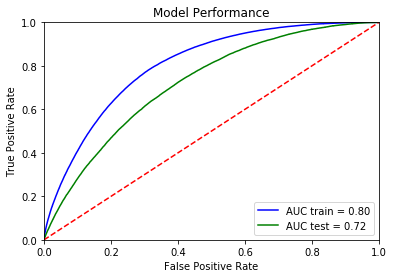

In [12]:
modelador.plot_roc_2(tree_clf,X_train,y_train,X_test,y_test)

In [10]:
modelador.plot_confusion_matrix(tree_clf,X_train,y_train)

[[3117779    2881]
 [ 716783    5174]]


In [11]:
modelador.plot_confusion_matrix(tree_clf,X_test,y_test)

[[1336090    1349]
 [ 307481    1916]]


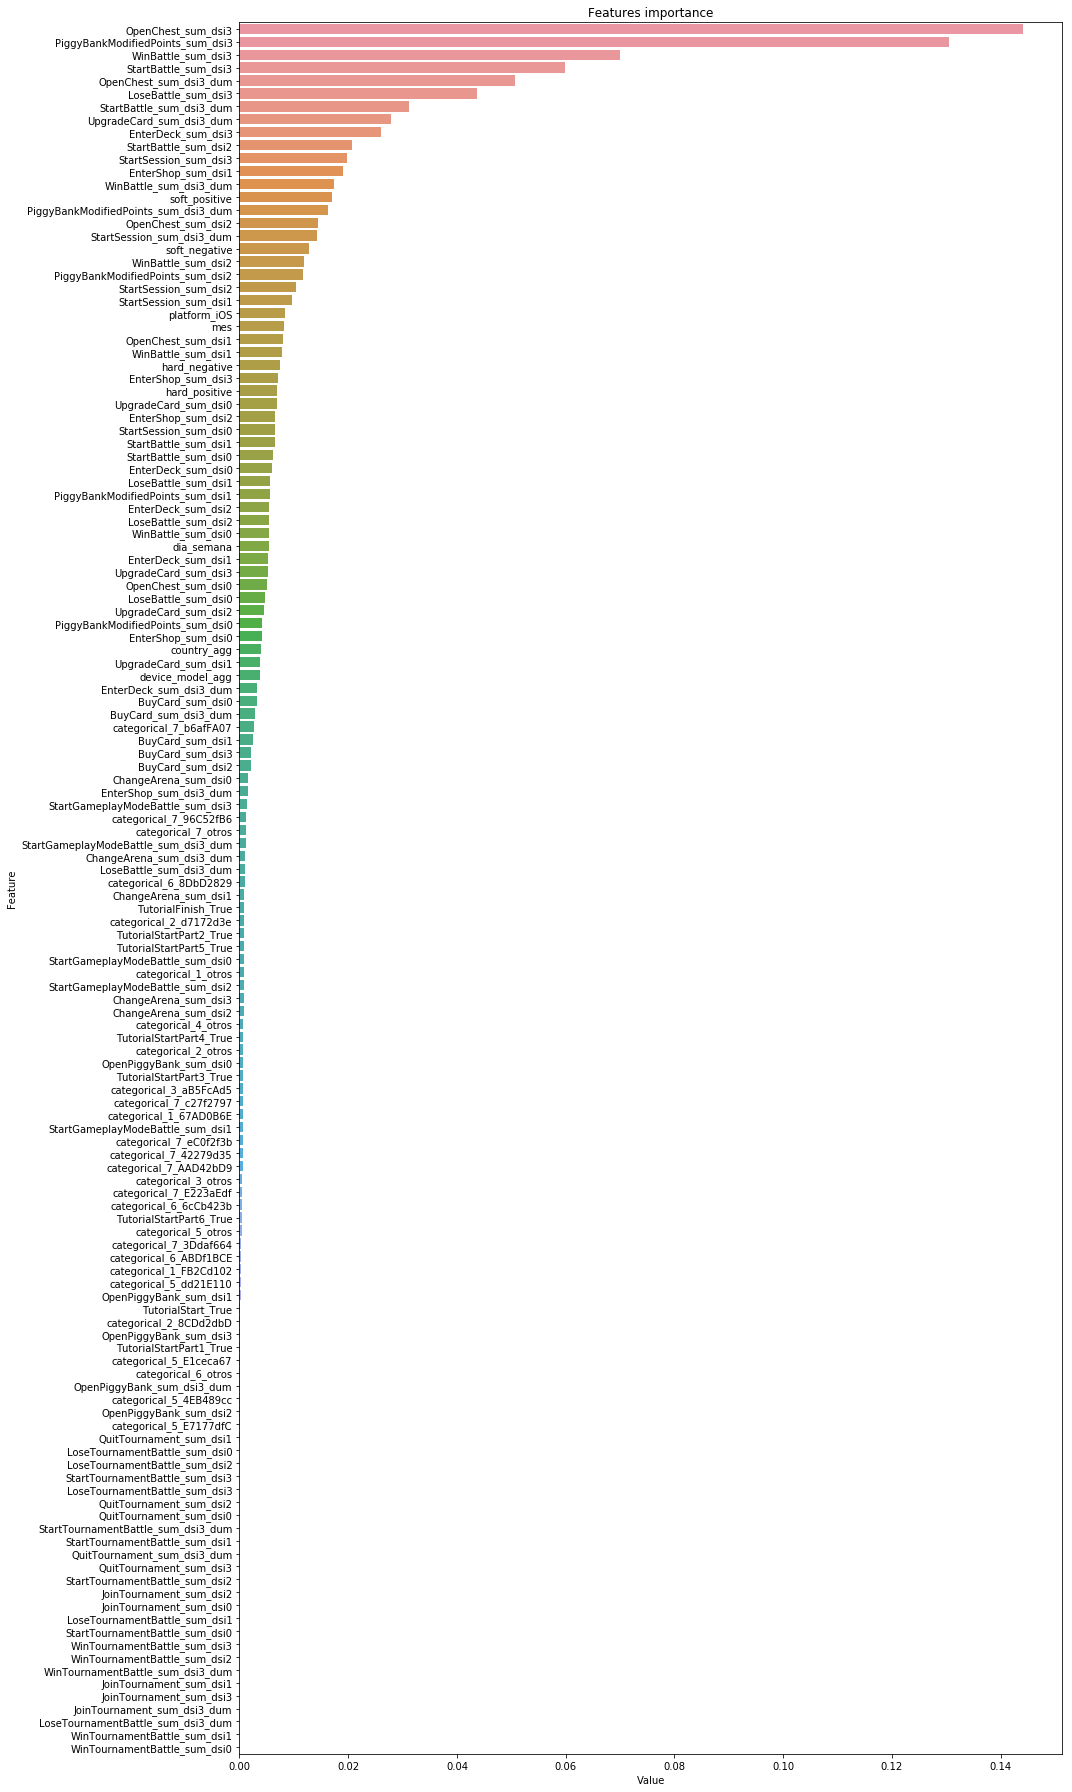

In [13]:
modelador.plot_feature_importance(tree_clf,X_train)

<h3>Guardado de modelos y creacion de submit para kaggle</h3>

In [331]:
# Predice 
probs = tree_clf.predict_proba(validation)
# Guarda resultados sobre validacion
md.guardar_submit(probs,"resultados_hoy")

AttributeError: module 'modeler_FF' has no attribute 'guardar_submit'

In [ ]:
# guardar modelo (pickle)
md.guardar_modelo(modelo,"nombreModelo")
# levantar modelo (pickle)
modelo = md.abrir_modelo("nombreModelo")

<h3>Tuneo de modelos</h3>

In [ ]:
# RANDOM SEARCH
n_folds = 3
n_iteraciones = 50

# Develop a grid with the most important features for Random Forest    
params = {
    "max_depth":[10,13,15], # Maximum number of levels in tree
    "max_features": ['auto', 0.3, 0.6, 0.9], # Number of features to consider at every split
    "min_samples_leaf": [1,3,4,6], # Minimum amount of samples to create a leaf
    "min_samples_split": [2,6,12,24], # Minimum amount of samples to split a node
    "max_leaf_nodes": [100, 1000, 3000], # Maximum amount of leaf by node
    "bootstrap": [True, False], # Method of selecting samples for training each tree
    "n_estimators": [10,100,1000,5000], # Number of trees in random forest
    }
 
                
features = df.loc[:, df.columns != 'Label']
labels = df.loc[:, df.columns == 'Label']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

result_trainRandom = md.tunner_random(model, params, X_train, y_train, n_folds, n_iteraciones)

In [ ]:
best_random = result_trainRandom.best_estimator_
modelador.plot_roc_2(best_random,X_train,y_train,X_test,y_test)
print(result_trainRandom.best_estimator_)

In [ ]:
# GRID SEARCH

# Ejemplo de tuner con "tunner_grid()"
model = RandomForestClassifier()
n_folds = 3

# Develop a grid with the most important features for Random Forest    
params = {
    "max_depth":[10,13,15], # Maximum number of levels in tree
    "max_features": ['auto', 0.3, 0.6, 0.9], # Number of features to consider at every split
    "min_samples_leaf": [1,3,4,6], # Minimum amount of samples to create a leaf
    "min_samples_split": [2,6,12,24], # Minimum amount of samples to split a node
    "max_leaf_nodes": [100, 1000, 3000], # Maximum amount of leaf by node
    "bootstrap": [True, False], # Method of selecting samples for training each tree
    "n_estimators": [10,100,1000,5000], # Number of trees in random forest
    }
 
                
features = df.loc[:, df.columns != 'Label']
labels = df.loc[:, df.columns == 'Label']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

result_trainGrid = md.tunner_grid(model, params, X_train, y_train, n_folds)

In [ ]:
best_random_2 = result_trainGrid.best_estimator_
modelador.plot_roc_2(best_random_2,X_train,y_train,X_test,y_test)
print(randomGrid.best_estimator_)

<h2>Analisis de componentes principales para feature importance (_dsi variables)</h2>

In [360]:
#https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis

In [278]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


names_dsiX = [col for col in df.columns if '_dsi' in col]

X = df[names_dsiX]

#In general a good idea is to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    

pca = PCA()
x_new = pca.fit_transform(X)

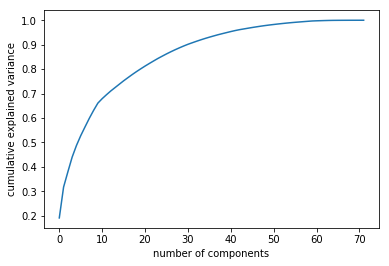

In [279]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [280]:
pca.explained_variance_ratio_

array([1.91452460e-01, 1.26041480e-01, 6.23652365e-02, 6.03157910e-02,
       4.73906471e-02, 4.02640947e-02, 3.57966626e-02, 3.51485937e-02,
       3.24420523e-02, 2.98069150e-02, 1.81514141e-02, 1.60712813e-02,
       1.53182904e-02, 1.39149990e-02, 1.38681510e-02, 1.38023523e-02,
       1.28658572e-02, 1.26960052e-02, 1.21293384e-02, 1.14648477e-02,
       1.11608962e-02, 1.06317698e-02, 1.03422882e-02, 1.01978014e-02,
       9.34157849e-03, 9.23708432e-03, 8.66912807e-03, 8.31990485e-03,
       7.79789853e-03, 7.52794521e-03, 7.00656120e-03, 6.26960808e-03,
       6.13187156e-03, 5.89074444e-03, 5.61473358e-03, 5.26593455e-03,
       4.98693148e-03, 4.89032406e-03, 4.43549962e-03, 4.36238379e-03,
       4.28000978e-03, 4.05560855e-03, 3.57388004e-03, 3.02947243e-03,
       3.00672088e-03, 2.98507792e-03, 2.74395400e-03, 2.68472351e-03,
       2.47710915e-03, 2.27974714e-03, 2.09669958e-03, 2.05972280e-03,
       1.86517171e-03, 1.82129059e-03, 1.66391453e-03, 1.53597547e-03,
      

In [283]:
names_dsiX = [col for col in df.columns if '_dsi' in col]
n_pc = 10

model = PCA(n_components=n_pc).fit(df[names_dsiX])
X_pc = model.transform(df[names_dsiX])

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = names_dsiX

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
important_features_pc = pd.DataFrame(dic.items())

In [284]:
# Features mas importantes por componente (independiente de Label)
important_features_pc

,0,1
0,PC0,PiggyBankModifiedPoints_sum_dsi0
1,PC1,OpenChest_sum_dsi3
2,PC2,StartBattle_sum_dsi1
3,PC3,StartBattle_sum_dsi0
4,PC4,StartBattle_sum_dsi1
5,PC5,PiggyBankModifiedPoints_sum_dsi3
6,PC6,PiggyBankModifiedPoints_sum_dsi3
7,PC7,PiggyBankModifiedPoints_sum_dsi2
8,PC8,PiggyBankModifiedPoints_sum_dsi2
9,PC9,UpgradeCard_sum_dsi0


<h2>Ingenieria de atributos</h2>

In [147]:
# ATRIBUTOS MAS IMPORTANTES SEGUN DISTINTOS MODELOS
"""
- install_date                         --> Se crearon las variables dia_semana y mes, y se saco la variable cruda
- platform_iOS
- StartSession_sum_dsi3                --> Dummies cortando por el mejor cuartil para todas las sum_dsiX
- OpenChest_sum_dsi3
- StartBattle_sum_dsi3
- PiggyBankModifiedPoints_sum_dsi3
- hard_positive
- hard_negative
- soft_positive
- soft_negative
- device_model (no la agg)
"""


<b>DIA DE SEMANA</b>

In [211]:
# Funciom dia de la semana
d = {'dia': [], 'dia_semana': []}
df_week_table = pd.DataFrame(data=d)

dia_sem = 0
for i in range(0,2000):
    if dia_sem==7:
        dia_sem=0
    dia_sem += 1
    df_week_table = df_week_table.append({'dia': i, 'dia_semana': dia_sem}, ignore_index=True)

df = df.merge(df_week_table, right_on="dia", left_on="install_date", how='left')  
df.drop(['dia'], axis=1, inplace = True) 


In [231]:
df.drop(['install_date'], axis=1, inplace = True) 

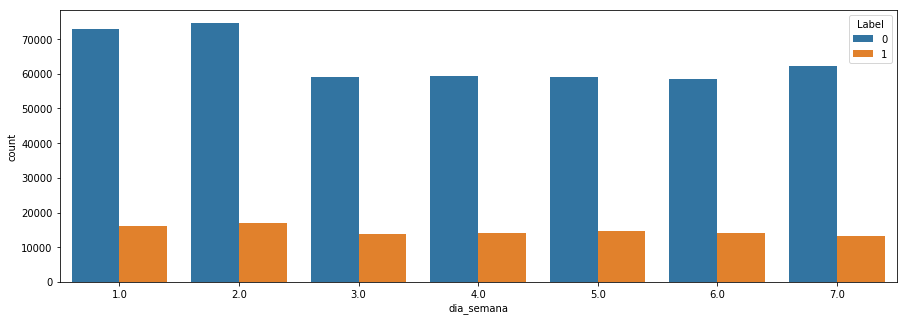

In [180]:
# Semana distribuida por dias. 1 y 2 son sabado y domingo?
s = df.merge(df_week_table, right_on="dia", left_on="install_date", how='left')

plt.subplots(figsize=(15,5))
sns.countplot(x="dia_semana", hue="Label", data=s)

<b>MES</b>

In [99]:
d = {'dia': [], 'mes': []}
df_mes_table = pd.DataFrame(data=d)

mes = 1
dias_mes = 0
for i in range(0,2000):
    if mes==12:
        mes=1
    if dias_mes==30:
        dias_mes=0
        mes+=1
    dias_mes += 1
    df_mes_table = df_mes_table.append({'dia': i, 'mes':mes}, ignore_index=True)

df = df.merge(df_mes_table, right_on="dia", left_on="install_date", how='left')  
df.drop(['dia'], axis=1, inplace = True) 


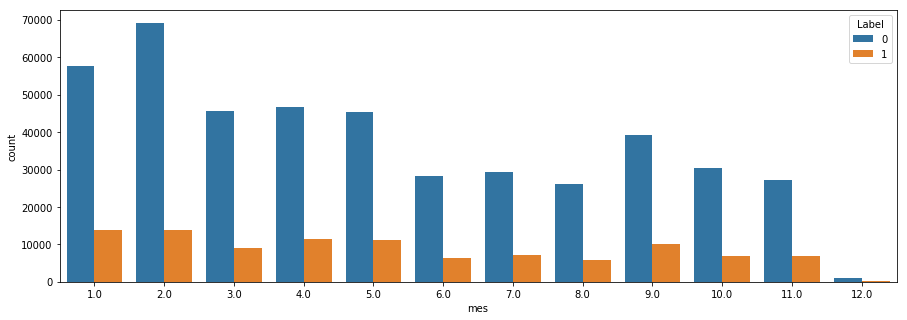

In [181]:
# Mes distribuido por dias. 
s = df.merge(df_mes_table, right_on="dia", left_on="install_date", how='left')

plt.subplots(figsize=(15,5))
sns.countplot(x="mes", hue="Label", data=s)

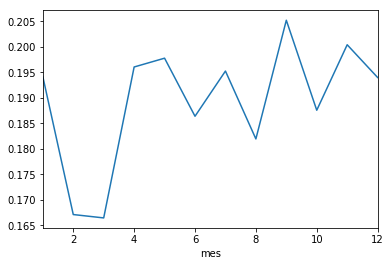

In [187]:
# probabilidad de churn por mes

a = s.groupby("mes").Label.sum()/s.groupby("mes").Label.count()
a.plot.line()

In [173]:
# En validation tenemos 2 meses? podran ser Febrero y Marzo? (28 + 31 = 59 )

mybins = range(int(validation.install_date.min()), int(validation.install_date.max()), 28)
s = pd.cut(validation.install_date, bins=mybins).dropna()

print(int(validation.install_date.max()))
s.value_counts()

400


(428, 456]    327013
(400, 428]    292411
Name: install_date, dtype: int64

<b>TRANSFORMACION LOGARITMICA</b>

In [ ]:
# No funciono

In [1]:
# https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

In [280]:
df[names_dsiX] = df[names_dsiX] + 1
df[names_dsiX] = df[names_dsiX].apply(np.log)

<b>TOP STANDARIZATION</b>

In [ ]:
lista_columnas_num = list(df.select_dtypes(include=['int64','float64']).columns)
df_aux = df[lista_columnas_num]
df[lista_columnas_num] = df_aux[(np.abs(stats.zscore(df_aux)) < 3).all(axis=1)] # Remove outliers
z = np.abs(stats.zscore(df[lista_columnas_num]))
print(z)

#df["abv"].apply(np.log)

<b>TENDENCIAS</b>

In [ ]:
# No funciono

In [148]:
# Desde dsi0 a dsi3 con que tendencias viene X variable

In [37]:
def tendencia(df,nc):
    df.loc[df[nc+'_sum_dsi0'] + df[nc+'_sum_dsi1'] < df[nc+'_sum_dsi2'] + df[nc+'_sum_dsi3'],nc+"_tendencia"]=1
    df.loc[df[nc+'_sum_dsi0'] + df[nc+'_sum_dsi1'] > df[nc+'_sum_dsi2'] + df[nc+'_sum_dsi3'],nc+"_tendencia"]=-1
    df.loc[df[nc+'_sum_dsi0'] + df[nc+'_sum_dsi1'] == df[nc+'_sum_dsi2'] + df[nc+'_sum_dsi3'],nc+"_tendencia"]=0
    return df

In [38]:
names_dsiX = ['OpenPiggyBank',
                'StartBattle',
                'EnterShop',
                'EnterDeck',
                'StartSession',
                'WinBattle',
                'OpenChest',
                'LoseBattle']

In [39]:
for i in names_dsiX:
    df = tendencia(df,i)

<b>CORTES DUMMIES POR CUARTILES</b>

La idea es esta variable es dividir mejor a las sum_dsiX. En gral observamos que quienes tienen menor probabilidad de churn son quienes mas interactuan con el juego y que por lo tanto presentan mayores valores de sum_dsiX. Esto se observa, por ejemplo en la variable "PiggyBankModifiedPoints_sum_dsi3" y su distribucion separada por Label que aparece en el siguiente grafico.

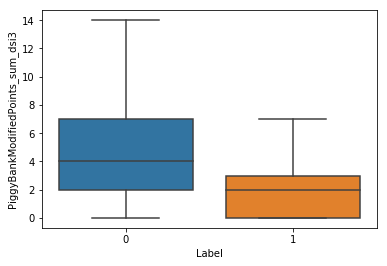

In [97]:
sns.boxplot(x="Label", y="PiggyBankModifiedPoints_sum_dsi3", data=df, showfliers = False)

Sus distribuciones se superponen. Por lo tanto, hay que elegir un punto de corte. Podria ser a partir del cuartil 3 de label 1 o a partir del cuartil 1 de label 0. La pregunta que surge inmediatamente es, cual es mejor? existe una diferencia entre cortar por uno o por otro?

Para responder la pregunta anterior se desarrollo la funcion que se presenta a continuacion. En ella, se evalua cuantos 0s vs 1s (valores de label) se pierden o se ganan por elegir un corte u otro.

In [234]:
def que_es_mejor(df,nombreCol):
    
    #Cuantos ceros sacrifico
    cant_0s_Mas1s = df[(df[nombreCol] < df[df.Label==1][nombreCol].quantile(0.75)) 
                       & (df.Label == 0)][nombreCol].count()
    
    cant_0s_Menos1s = df[(df[nombreCol] < df[df.Label==0][nombreCol].quantile(0.25)) 
                       & (df.Label == 0)][nombreCol].count()
    
    ceros_a_favor = (cant_0s_Mas1s - cant_0s_Menos1s)
    
    #Cuantos unos sacrifico
    cant_1s_Mas0s = df[(df[nombreCol] < df[df.Label==1][nombreCol].quantile(0.75)) 
                       & (df.Label == 1)][nombreCol].count()
    
    cant_1s_Menos0s = df[(df[nombreCol] < df[df.Label==0][nombreCol].quantile(0.25)) 
                       & (df.Label == 1)][nombreCol].count()
    
    unos_a_favor = cant_1s_Mas0s - cant_1s_Menos0s
    

    print(nombreCol)
    
    if ceros_a_favor != 0 or unos_a_favor != 0:
        print("Cantidad de 0s ganados: ",str(ceros_a_favor))
        print("Cantidad de 1s ganados: ",str(unos_a_favor))
    if ceros_a_favor == 0 and unos_a_favor == 0:
        print("Mean de 0s ganados: ",str(df[df.Label==0][nombreCol].mean()))
        print("Mean de 1s ganados: ",str(df[df.Label==1][nombreCol].mean()))
    print()

La ejecutamos para el ejemplo de "PiggyBankModifiedPoints_sum_dsi3" y vemos que si cortamos a favor de 0 ganamos mas 0s que si cortamos a favor de 1s para los valores de Label. Como el costo de hacer churn o no, no fue definido, para este caso, que el modelo prediga que una persona realizara churn vs una que no lo realizara es el mismo, por lo que las cantidades son directamente comparables.

In [98]:
que_es_mejor(df,"PiggyBankModifiedPoints_sum_dsi3")

Cantidad de 0s ganados: 32409
Cantidad de 1s ganados: 10257


Sirve de algo esto? el resultado lo vemos en el grafico de feature importance a continuacion, donde se observa que priorizar 0s hace que el corte de la nueva variable dummie sea casi tan importante que la variable original, mientras que la variable que prioriza los 1s es mucho menos importante. (ver imagen feature importance)

In [ ]:
df["prioridad_1s"] = 0
df.loc[(df.PiggyBankModifiedPoints_sum_dsi3 < df[df.Label==1].PiggyBankModifiedPoints_sum_dsi3.quantile(0.75)),"prioridad_1s"]=1

df["prioridad_0s"] = 0
df.loc[(df.PiggyBankModifiedPoints_sum_dsi3 < df[df.Label==0].PiggyBankModifiedPoints_sum_dsi3.quantile(0.25)),"prioridad_0s"]=1

In [231]:
def dummies_for_dsi(df):
    names_dsiX = [col for col in df.columns if '_dsi' in col]
    for i in names_dsiX:
        que_es_mejor(df,i)
        

In [235]:
dummies_for_dsi(df)

BuyCard_sum_dsi0
Cantidad de 0s ganados:  293633
Cantidad de 1s ganados:  72984

BuyCard_sum_dsi1
Mean de 0s ganados:  1.9207615715823465
Mean de 1s ganados:  1.3769764620237805

BuyCard_sum_dsi2
Mean de 0s ganados:  1.5769891460351633
Mean de 1s ganados:  1.0100946372239747

BuyCard_sum_dsi3
Mean de 0s ganados:  1.5146528525296017
Mean de 1s ganados:  0.8114049987867022

ChangeArena_sum_dsi0
Mean de 0s ganados:  1.0339612486544671
Mean de 1s ganados:  0.9181169619024508

ChangeArena_sum_dsi1
Mean de 0s ganados:  0.35698780050233225
Mean de 1s ganados:  0.2203154574132492

ChangeArena_sum_dsi2
Mean de 0s ganados:  0.27274174739863655
Mean de 1s ganados:  0.13891773841300656

ChangeArena_sum_dsi3
Mean de 0s ganados:  0.20712683889486905
Mean de 1s ganados:  0.07584566852705654

EnterDeck_sum_dsi0
Cantidad de 0s ganados:  176794
Cantidad de 1s ganados:  43220

EnterDeck_sum_dsi1
Cantidad de 0s ganados:  253498
Cantidad de 1s ganados:  73683

EnterDeck_sum_dsi2
Cantidad de 0s ganados:  23

<b>CONCLUSION</b>

Se probo cambiar el Q3 del label 1 por el Q2 del label 1 y en todos los casos parece siempre convenir cortar por el Q1 del label 0. Existen casos en los que el Q1 del label 0 es igual al Q2 y Q3 de label 1. En ese caso se definirá el corte por diferencia de medias.

<h3>Interaccion entre numericas</h3>

In [387]:
df.loc[df.WinBattle_sum_dsi3 > df.StartBattle_sum_dsi3,"win_vs_tot"]=1
#df["win_vs_tot"] = (df.WinBattle_sum_dsi3 / df.StartBattle_sum_dsi3)
#df["win_vs_tot"].fillna(0, inplace=True)
#df[df.win_vs_tot == float('inf')].win_vs_tot
#df[win_vs_tot] = df.win_vs_tot.replace(np.inf, 1)
df[df.index == 4545].win_vs_tot

4545    1.0
Name: win_vs_tot, dtype: float64

In [49]:

#df["Enter_vs_SoftP"] = (df.soft_positive / df.EnterDeck_sum_dsi3)
df.loc[df.soft_positive / df.EnterDeck_sum_dsi3 == float('inf'),"Enter_vs_SoftP"]=1
#df["Enter_vs_SoftP"].fillna(0, inplace=True)
df.Enter_vs_SoftP.describe()

count    5.489453e+06
mean     1.073813e+03
std      1.410238e+06
min      0.000000e+00
25%      1.000000e+00
50%      1.626000e+02
75%      4.326667e+02
max      3.294968e+09
Name: Enter_vs_SoftP, dtype: float64

In [55]:
df["Open_vs_Start"] = (df.OpenChest_sum_dsi3 / df.StartBattle_sum_dsi3)
df.loc[df.OpenChest_sum_dsi3 / df.StartBattle_sum_dsi3 == float('inf'),"Open_vs_Start"]=1
df["Open_vs_Start"].fillna(0, inplace=True)
df.Enter_vs_SoftP.describe()

count    5.489453e+06
mean     1.073813e+03
std      1.410238e+06
min      0.000000e+00
25%      1.000000e+00
50%      1.626000e+02
75%      4.326667e+02
max      3.294968e+09
Name: Enter_vs_SoftP, dtype: float64